In [13]:
# Run if you are on Google Colab to install the Python bindings
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
copying build/lib.macosx-10.9-x86_64-3.6/screening.cpython-36m-darwin.so -> 


In [14]:
import argparse
import os
import numpy as np
from scipy.fftpack import dctn, idctn
import math
import sys
import copy
import matplotlib.pyplot as plt
from screening import function1, HelperClass

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)

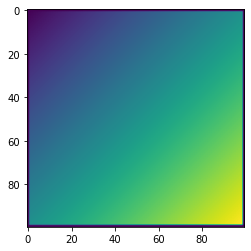

In [15]:
phi = np.zeros((100,100))
function1(phi,phi)
plt.imshow(phi)

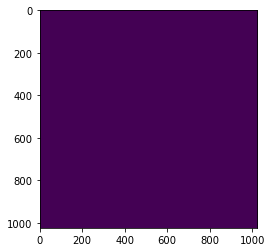

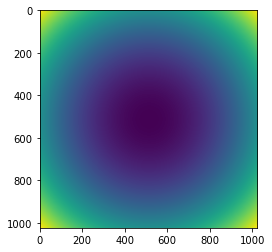

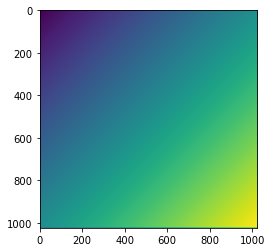

In [16]:
n = 1024

xx,yy = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,n))

f = np.zeros((n,n))
X = (xx-0.5)**2 + (yy-0.5)**2

plt.imshow(f)
plt.show()
plt.imshow(X)
plt.show()
function1(f,X)
plt.imshow(f)
plt.show()

# Poisson solver with Neumann boundary conditions

Solving the following problem on the domain $\Omega= [0,1]^2$,
$$- \Delta u = f $$
$$ \partial_n u = g $$
where
$$ f(x,y) = \cos(\pi x + C) \cos(\pi y + C) $$
$$ u(x,y) = \frac{1}{(2\pi)^2}\cos(\pi x + C) \cos(\pi y + C) $$
$$ g_x(x,y) = - \frac{1}{4\pi} \sin(\pi x + C)\cos(\pi y + C) $$
$$ g_y(x,y) = - \frac{1}{4\pi} \cos(\pi x + C)\sin(\pi y + C) $$

Text(0.5, 1.0, 'initial density')

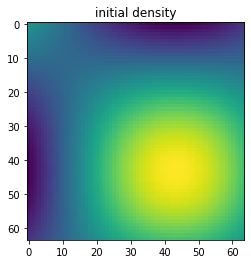

In [27]:
# Poisson Solver
# Solving -\Delta u = f with a boundary condition \partial_n u = g (Neummann)

f = np.zeros((n,n))
u = np.zeros_like(f)
X, Y = np.meshgrid(np.linspace(0.5/n,1-0.5/n,n), np.linspace(0.5/n,1-0.5/n,n))
yMax = 5
X*=yMax
Y*=yMax
C = 1
f = np.cos(X/yMax * np.pi + C) * np.cos(Y/yMax * np.pi + C)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(f)
ax.set_title("initial density")

In [28]:
# Initialize Fourier kernel
def initialize_kernel(n1, n2, dy):
    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    # kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))
    kernel = 2*(1-np.cos(xx))/(dy*dy) + 2*(1-np.cos(yy))/(dy*dy)
    kernel[0,0] = 1     # to avoid dividing by zero
    return kernel

# 2d DCT
def dct2(a):
    return dctn(a, norm='ortho')

# 2d IDCT
def idct2(a):
    return idctn(a, norm='ortho')

# Solving Poisson
#   - Δ u = f
#   output: u = (-Δ)⁻¹ f
def solve_poisson(u, f, kernel):
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

def solve_poisson_bdry(u, f, bdry, kernel):
    gx0, gx1, gy0, gy1 = bdry
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace[0,:]   -= gy0 * n
    workspace[n-1,:] += gy1 * n
    workspace[:,0]   -= gx0 * n
    workspace[:,n-1] += gx1 * n
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

In [29]:
x0 = 0
x1 = 1
y0 = 0
y1 = 1
xx = np.linspace(0.5/n,1-0.5/n,n)
gy0 = -1.0/(2.0*np.pi) * np.cos(np.pi * xx + C) * np.sin(np.pi * y0 +  C)
gy1 = -1.0/(2.0*np.pi) * np.cos(np.pi * xx + C) * np.sin(np.pi * y1 +  C)
gx0 = -1.0/(2.0*np.pi) * np.sin(np.pi * x0 + C) * np.cos(np.pi * xx +  C)
gx1 = -1.0/(2.0*np.pi) * np.sin(np.pi * x1 + C) * np.cos(np.pi * xx +  C)


Text(0.5, 1.0, 'error: 1.5663474332772658e-08')

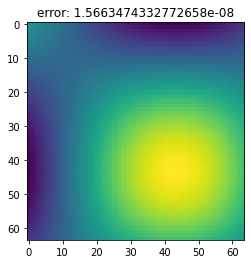

In [30]:
# Testing poisson solver
kernel = initialize_kernel(n, n, 1.0/n*yMax)
solve_poisson_bdry(u,f,[gx0,gx1,gy0,gy1],kernel)
plt.imshow(u)
plt.title(f"error: {np.mean( (u - u.mean() - (f - f.mean()) * (0.5/(np.pi/yMax)**2))**2 )}")

# c-transform

$$ \phi^c(x) = \inf_y c(x,y) + \phi(y) $$

$$ c(x,y) = \frac12 |y|^2$$

$$ \phi^c(x) = \inf_y \frac12 |y|^2 + \phi(y) $$

In [31]:
# centered difference
def compute_dx(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[1:-1,0]    = phi[:,0]
  # tmp[1:-1,-1]   = phi[:,-1]
  # tmp[1:-1,1:-1] = phi
  A = np.zeros_like(phi)
  A[:,1:-1] = (phi[:,2:] - phi[:,:-2])/(2.0*dy)
  A[:,0]    = (phi[:,1] - phi[:,0])/(1.0*dy)
  A[:,-1]   = (phi[:,-1] - phi[:,-2])/(1.0*dy)
  return A

def compute_dx_forward(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[:,:-1] = (phi[:,1:] - phi[:,:-1])/(1.0*dy)
  A[:,-1]  = (phi[:,-1] - phi[:,-2])/(1.0*dy)
  return A

def compute_dx_back(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[:,1:] = (phi[:,1:] - phi[:,:-1])/(1.0*dy)
  A[:,0]  = (phi[:,1]  - phi[:,0])/(1.0*dy)
  return A

def compute_dxx(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[1:-1,0]    = phi[:,0]
  # tmp[1:-1,-1]   = phi[:,-1]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[1:-1,2:] + tmp[1:-1,:-2] - 2.0 * tmp[1:-1,1:-1])/(dy*dy)

  A = compute_dx_forward(phi, tmp, dy)
  return compute_dx_back(A, tmp, dy)

# centered difference
def compute_dy(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[0,1:-1]    = phi[0,:]
  # tmp[-1,1:-1]   = phi[-1,:]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[2:,1:-1] - tmp[:-2,1:-1])/(2.0*dy)

  A = np.zeros_like(phi)
  A[1:-1,:] = (phi[2:,:] - phi[:-2,:])/(2.0*dy)
  A[0,:]    = (phi[1,:] - phi[0,:])/(1.0*dy)
  A[-1,:]   = (phi[-1,:] - phi[-2,:])/(1.0*dy)
  return A

def compute_dy_forward(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[:-1,:] = (phi[1:,:] - phi[:-1,:])/(1.0*dy)
  A[-1,:]  = (phi[-1,:] - phi[-2,:])/(1.0*dy)
  return A

def compute_dy_back(phi, tmp, dy):
  A = np.zeros_like(phi)
  A[1:,:] = (phi[1:,:] - phi[:-1,:])/(1.0*dy)
  A[0,:]  = (phi[1,:] - phi[0,:])/(1.0*dy)
  return A

def compute_dyy(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[0,1:-1]    = phi[0,:]
  # tmp[-1,1:-1]   = phi[-1,:]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[2:,1:-1] + tmp[:-2,1:-1] - 2.0 * tmp[1:-1,1:-1])/(dy*dy)

  A = compute_dy_forward(phi, tmp, dy)
  return compute_dy_back(A, tmp, dy)

# centered difference
def compute_dxy(phi, tmp, dy):
  # n = phi.shape[0]
  # tmp[0,0]     = phi[0,0]
  # tmp[0,-1]    = phi[0,-1]
  # tmp[-1,0]    = phi[-1,0]
  # tmp[-1,-1]   = phi[-1,-1]
  # tmp[1:-1,0]  = phi[:,0]
  # tmp[1:-1,-1] = phi[:,-1]
  # tmp[0,1:-1]  = phi[0,:]
  # tmp[-1,1:-1] = phi[-1,:]
  # tmp[1:-1,1:-1] = phi
  # return (tmp[2:,2:] - tmp[2:,:-2] - tmp[:-2,2:] + tmp[:-2,:-2])/(4.0*dy*dy)
  # A = compute_dx_back(phi, tmp, dy)
  A = np.zeros_like(phi)
  A[:-1,:-1] = (phi[1:,1:] - phi[1:,:-1] - phi[:-1,1:] + phi[:-1,:-1])/(dy*dy)
  A[-1,:-1]  = - (phi[-1,:-1] - phi[-1,1:] - phi[-2,:-1] + phi[-2,1:])  /(dy*dy)
  A[:-1,-1]  = - (phi[:-1,-1] - phi[:-1,-2] - phi[1:,-1] + phi[1:,-2])/(dy*dy)
  A[-1,-1]   = (phi[-1,-1] - phi[-1,-2] - phi[-2,-1] + phi[-2,-2])/(dy*dy)
  return A

In [32]:
from screening import compute_dxx, compute_dyy, compute_dxy, compute_dx, compute_dy

# performing c transform
# output: modified psi
def c_transform(psi: torch.tensor, phi: torch.tensor, cost: torch.tensor):
  n = phi.shape[0]
  psi[:] = torch.min(cost + phi.view((1,n*n)), dim=1).values.view((n,n))

def c_transform_forward(phi: torch.tensor, psi: torch.tensor, cost: torch.tensor):
  n = phi.shape[0]
  phi[:] = torch.min(cost + psi.view((n*n,1)), dim=0).values.view((n,n))

# push forward
def approx_push(nu: torch.tensor, psi: torch.tensor, phi: torch.tensor, cost: torch.tensor, epsilon: float, dx: float, dy: float):
  mat   = torch.exp((psi.view((n*n,1)) - phi.view((1,n*n)) - cost) / epsilon) # mat = (n*n, n*n) matrix
  mat /= torch.sum(mat, dim=1).view((n*n,1)) * dy
  nu[:] = torch.sum(mat, dim=0).view((n,n)) * dx

def compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=False):
  n = phi_np.shape[0]
  tmp = np.zeros((n+2,n+2))

  # the following codes compute the gradients using numpy arrays in python
  # phixx = compute_dxx(phi_np, tmp, dy)
  # phiyy = compute_dyy(phi_np, tmp, dy)
  # phixy = compute_dxy(phi_np, tmp, dy)
  # fx = compute_dx(phi_np-b, tmp, dy)
  # fy = compute_dy(phi_np-b, tmp, dy)

  # the following codes compute the gradients using through C++
  #   initialize fx, fy
  fx = np.zeros((phi_np.shape[0], phi_np.shape[1]))
  fy = np.zeros((phi_np.shape[0], phi_np.shape[1]))
  compute_dx(fx, phi_np-b, dy)
  compute_dy(fy, phi_np-b, dy)

#   det = phixx * phiyy - phixy * phixy
#   R1 = nu_np * (  phiyy * fx - phixy * fy) / det
#   R2 = nu_np * (- phixy * fx + phixx * fy) / det

  # R1 = np.zeros_like(phi_np)
  # R2 = np.zeros_like(phi_np)

  R1 = np.zeros((phi_np.shape[0],phi_np.shape[1]))
  R2 = np.zeros((phi_np.shape[0],phi_np.shape[1]))

  # if show_image == True:
  #   fig,ax=plt.subplots(1,3)
  #   ax[0].imshow(R1, origin='lower')
  #   ax[0].set_title("BEFORER1")
  #   ax[1].imshow(R2, origin='lower')
  #   ax[1].set_title("BEFORE R2")
  #   ax[2].imshow(phiyy, origin='lower')
  #   ax[2].set_title("phiyy")
  #   plt.show()

  helper.compute_inverse_g(R1, R2, phi_np, psi_np, fx, fy)

  # if show_image == True:
  #   fig,ax=plt.subplots(1,3)
  #   ax[0].imshow(R1, origin='lower')
  #   ax[0].set_title("R1")
  #   ax[1].imshow(R2, origin='lower')
  #   ax[1].set_title("R2")
  #   ax[2].imshow(phiyy, origin='lower')
  #   ax[2].set_title("phiyy")
  #   plt.show()
    
  R1 = nu_np * R1
  R2 = nu_np * R2

  R1x = compute_dx_forward(R1, tmp, dy)
  R2y = compute_dy_forward(R2, tmp, dy)

  gx0 = R1[:,0]
  gx1 = R1[:,-1]

  gy0 = R2[0,:]
  gy1 = R2[-1,:]

  return nu_np + R1x + R2y, [gx0,gx1,gy0,gy1]


def solve_poisson(u, phi_np, psi_np, nu_np, b, kernel, helper, dx, dy, yMax, show_image=False):
  rhs, bdry = compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=show_image) # computing the right hand side
  solve_poisson_bdry(u,rhs,bdry,kernel)
  return rhs

In [35]:

from IPython import display

# parameters
# grid size n x n
n = 64

# step size for the gradient ascent
L = 500

# epsilon for pushforward
epsilon = 0.1
max_iteration = 10000000

X, Y = np.meshgrid(np.linspace(0.5/n,1-0.5/n,n), np.linspace(0.5/n,1-0.5/n,n))

Xx = X + 1
Xy = Y + 1
yMax = 8
Yx = yMax * X
Yy = yMax * Y

dx = 1.0/n
dy = dx * yMax

# kernel = initialize_kernel(n, n, dy)
kernel = initialize_kernel(n, n, 1.0/n*yMax)

Xv = np.zeros((n*n,2))
Xv[:,0] = Xx.reshape((n*n,))
Xv[:,1] = Xy.reshape((n*n,))

Yv = np.zeros((n*n,2))
Yv[:,0] = Yx.reshape((n*n,))
Yv[:,1] = Yy.reshape((n*n,))

phi = 0.5*(Yx**2+Yy**2)
phi-= np.mean(phi)

cost = - np.sum(Xv.reshape((n*n,1,2)) * Yv.reshape((1,n*n,2)),axis=2)
psi  = torch.zeros((n,n)).type(torch.float32)
nu   = torch.zeros((n,n)).type(torch.float32)
b    = 0.5 * (Yx**2 + Yy**2)
phi  = torch.from_numpy(phi).type(torch.float32)
cost = torch.from_numpy(cost).type(torch.float32)

helper = HelperClass(phi, dx, dy)

if cuda:
  phi  = phi.cuda()
  psi  = psi.cuda()
  cost = cost.cuda()
  nu   = nu.cuda()

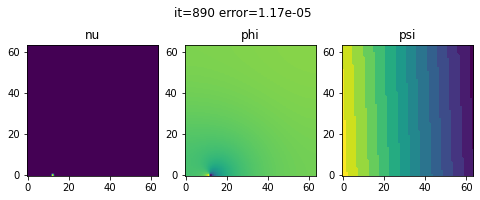

KeyboardInterrupt: 

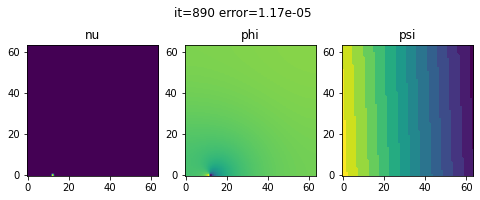

In [36]:
fig,ax = plt.subplots(1,3,figsize=(8,3))
hdisplay = display.display("", display_id=True)

for it in range(max_iteration):
  # c transform
  c_transform(psi, phi, cost)

  # print(f"min: {torch.min(psi.view((n*n,1)) - phi.view((1,n*n)) - cost)} max: {torch.max(psi.view((n*n,1)) - phi.view((1,n*n)) - cost)}")

  # pushforward mu -> nu
  approx_push(nu, psi, phi, cost, epsilon, dx, dy)

  # compute f (RHS) for the Poisson
  phi_np = phi.detach().cpu().numpy()
  psi_np = psi.detach().cpu().numpy()
  nu_np  = nu.detach().cpu().numpy()
  rhs = solve_poisson(u, phi_np, psi_np, nu_np, b, kernel, helper, dx, dy, yMax, show_image = (it%10==0))

  # gradient ascent
  error = np.mean(u**2)/L**2
  phi_np += 1.0/L * u

  if error == np.nan:
    print("wrong values")
    break

  if it % 10 == 0:
    ax[0].imshow(nu_np,origin='lower')
    ax[0].set_title("nu")
    ax[1].imshow(phi_np,origin='lower')
    ax[1].set_title("phi")
    ax[2].imshow(psi_np,origin='lower')
    ax[2].set_title("psi")
    plt.suptitle(f"it={it} error={error:0.2e}")
    plt.savefig(f"images/{it//10:03d}.png")
    hdisplay.update(fig)


    # fix,ax = plt.subplots(1,1)
    # A=psi.view((1,n*n)) - phi.view((n*n,1)) - cost
    # A = A.detach().cpu().numpy()
    # ax.imshow(A)
    # ax.set_title(f"{np.max(A)} {np.min(A)}")
    # plt.show()

  phi  = torch.from_numpy(phi_np).type(torch.float32)
  if cuda:
    phi = phi.cuda()

In [ ]:
import glob
import cv2

img_array = []
for filename in glob.glob('./images/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

from IPython.display import Video
Video("project.mp4")

In [ ]:
!rm images/*
